In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')
sys.path.insert(0, '../firmware')

In [2]:

import pandas
import seaborn
import numpy
np = numpy

from analysis import load_files

In [3]:

data = load_files('../data/one', fixup_shape=True)
print(data.shape)
data.head(5)

(1840, 23)


,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5034,5773,1670,7591,17984,1333,2034,2864,7309,...,5959,1795,1750,7589,17984,0,one_2500k_309lux.npy,one,309,2500
1,1571,5034,5773,1670,7592,17984,1333,2032,2862,7306,...,5961,1794,1750,7592,17980,1,one_2500k_309lux.npy,one,309,2500
2,1571,5037,5775,1670,7593,17984,1334,2032,2863,7307,...,5964,1796,1752,7595,17984,2,one_2500k_309lux.npy,one,309,2500
3,1572,5038,5773,1670,7596,17984,1333,2032,2862,7308,...,5963,1795,1750,7593,17981,3,one_2500k_309lux.npy,one,309,2500
4,1572,5040,5776,1671,7595,17982,1333,2035,2863,7307,...,5960,1795,1751,7592,17979,4,one_2500k_309lux.npy,one,309,2500


In [4]:
#sampled = data.groupby('filename', group_keys=False).sample(frac=1.0)
sampled = data.groupby('filename', group_keys=False).sample(frac=0.10)
#sampled = data.groupby('filename', group_keys=False).apply(lambda df: df.head(7).tail(1))
avg = sampled.groupby('filename').agg('median', numeric_only=True)
#avg = data.groupby('filename').agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,274.0,1206.0,1518.5,148.5,2131.5,17977.0,86.0,271.5,560.0,2061.0,...,17975.5,25.0,1536.0,208.0,264.5,2130.5,17977.5,14.0,100.0,2500.0
one_2500k_1lux.npy,5.0,11.0,10.0,16.0,19.0,587.5,2.5,5.0,8.0,13.0,...,587.5,1.0,13.0,9.0,3.0,19.0,587.5,9.5,1.0,2500.0
one_2500k_204lux.npy,737.5,2751.0,3311.5,614.5,4507.5,17980.5,457.5,856.5,1417.0,4350.5,...,17977.0,367.0,3380.0,720.0,777.0,4507.0,17982.0,13.0,204.0,2500.0
one_2500k_309lux.npy,1571.5,5038.0,5775.5,1670.0,7594.0,17978.0,1333.5,2033.5,2863.5,7307.0,...,17984.0,1264.0,5962.0,1794.5,1751.0,7592.0,17981.0,15.0,309.0,2500.0
one_2500k_408lux.npy,2431.0,7323.5,8194.5,2784.0,10597.5,17984.0,2265.0,3259.0,4331.0,10182.0,...,17981.5,2228.5,8515.5,2919.5,2760.0,10592.0,17983.0,14.0,408.0,2500.0


['ch_FZ', 'ch_FY', 'ch_FXL', 'ch_F2', 'ch_F3', 'ch_F4', 'ch_F6', 'ch_F1', 'ch_F7', 'ch_F8', 'ch_F5']
Fitting 5 folds for each of 25 candidates, totalling 125 fits


<string>:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.9840       0.9543       0.0297      
RMSE                      29.2787      34.2796      5.0009      
Mean Absolute Error       23.2916      22.6099      0.6818      
Sample Size               67           25          


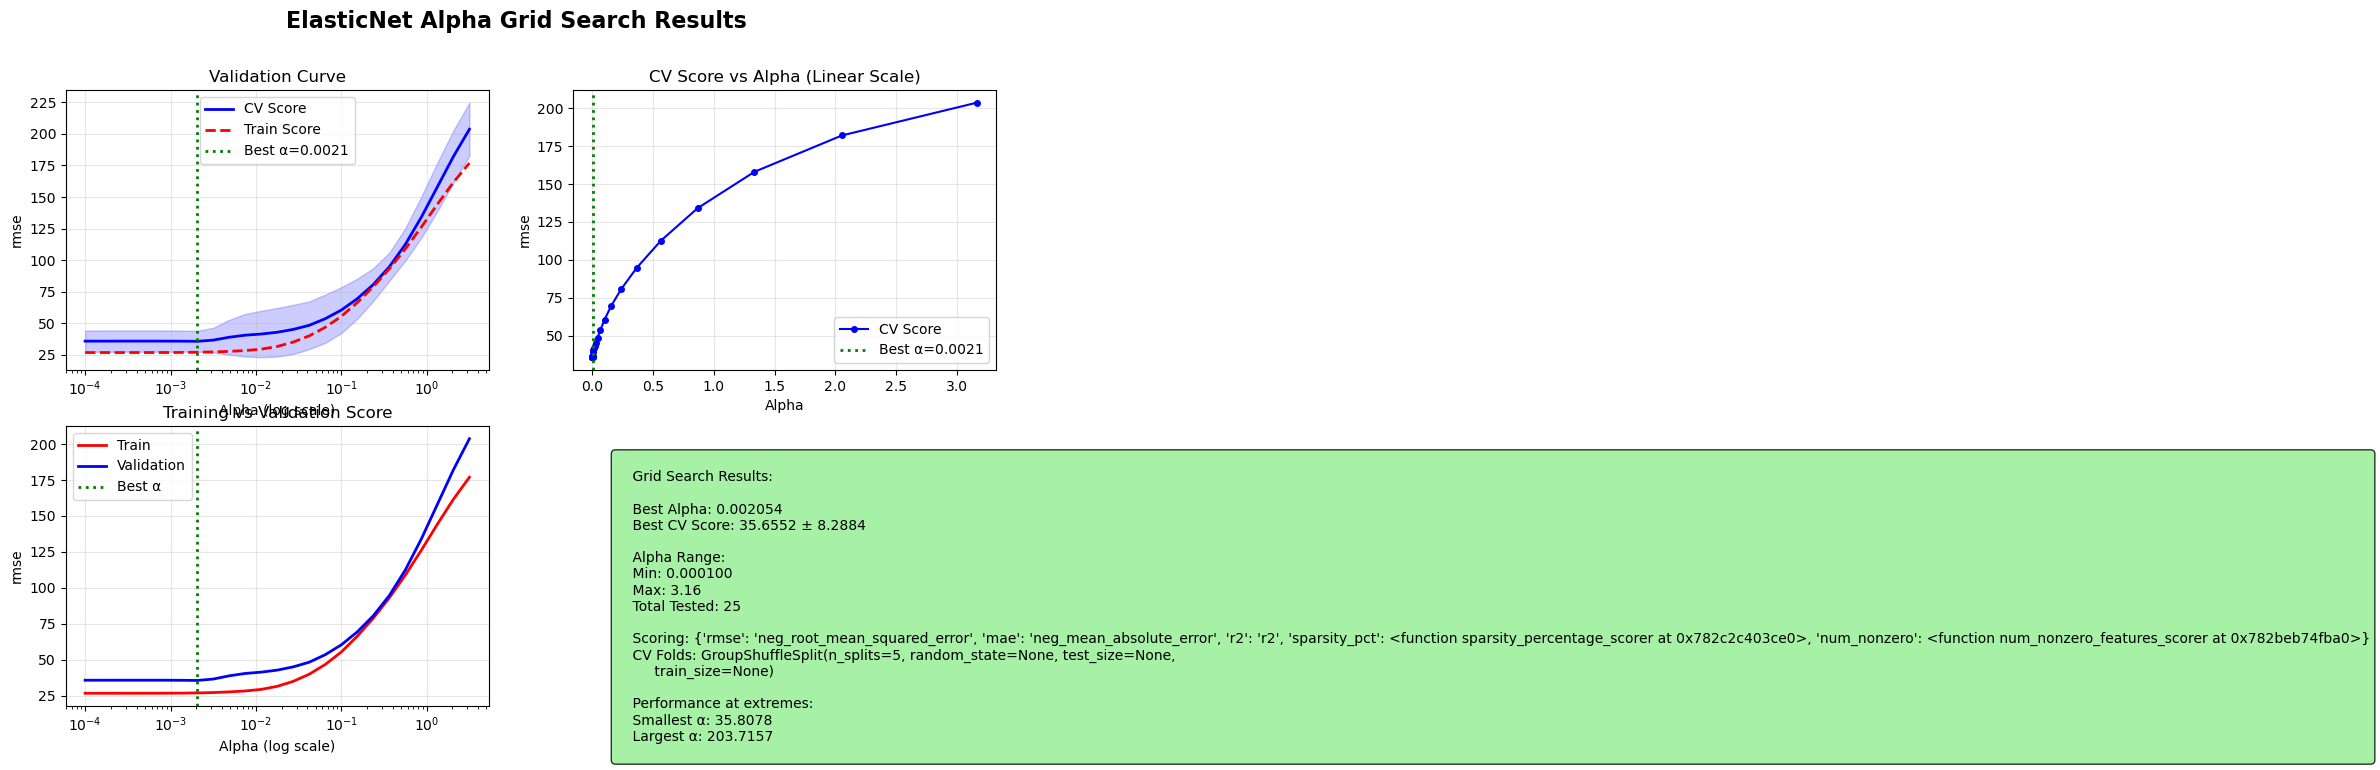

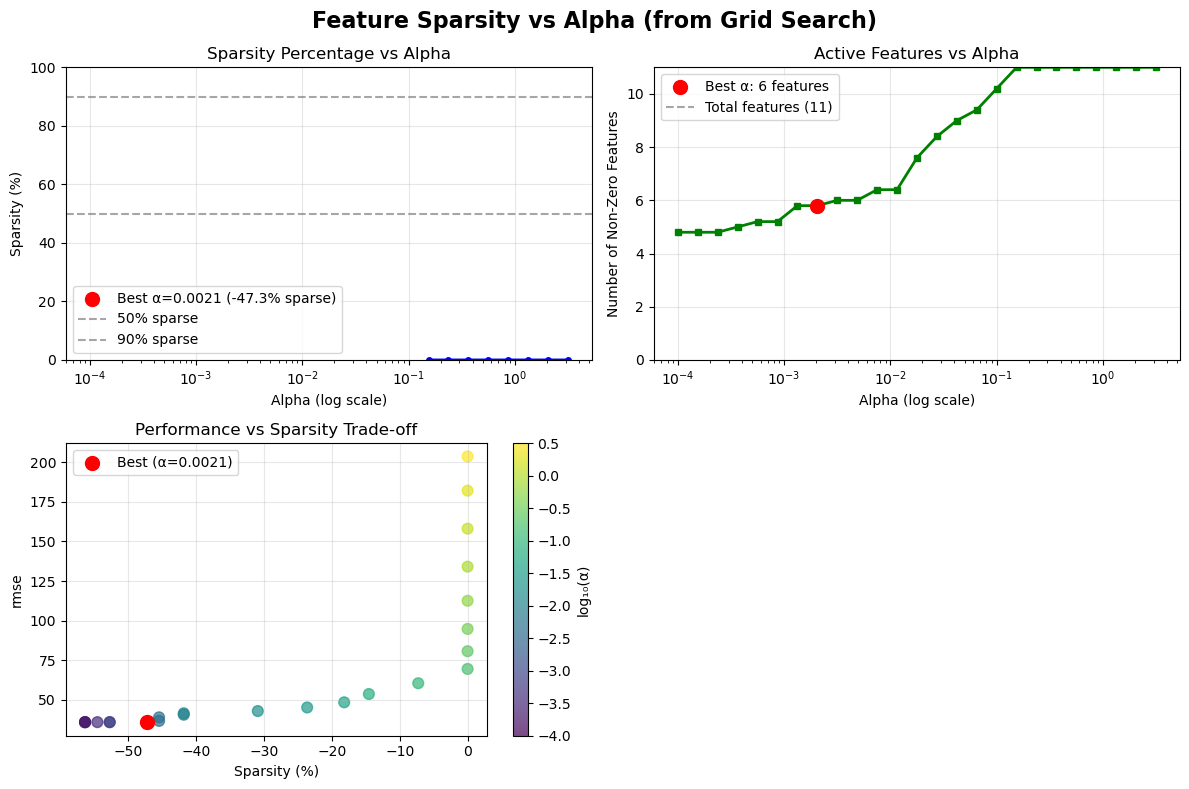

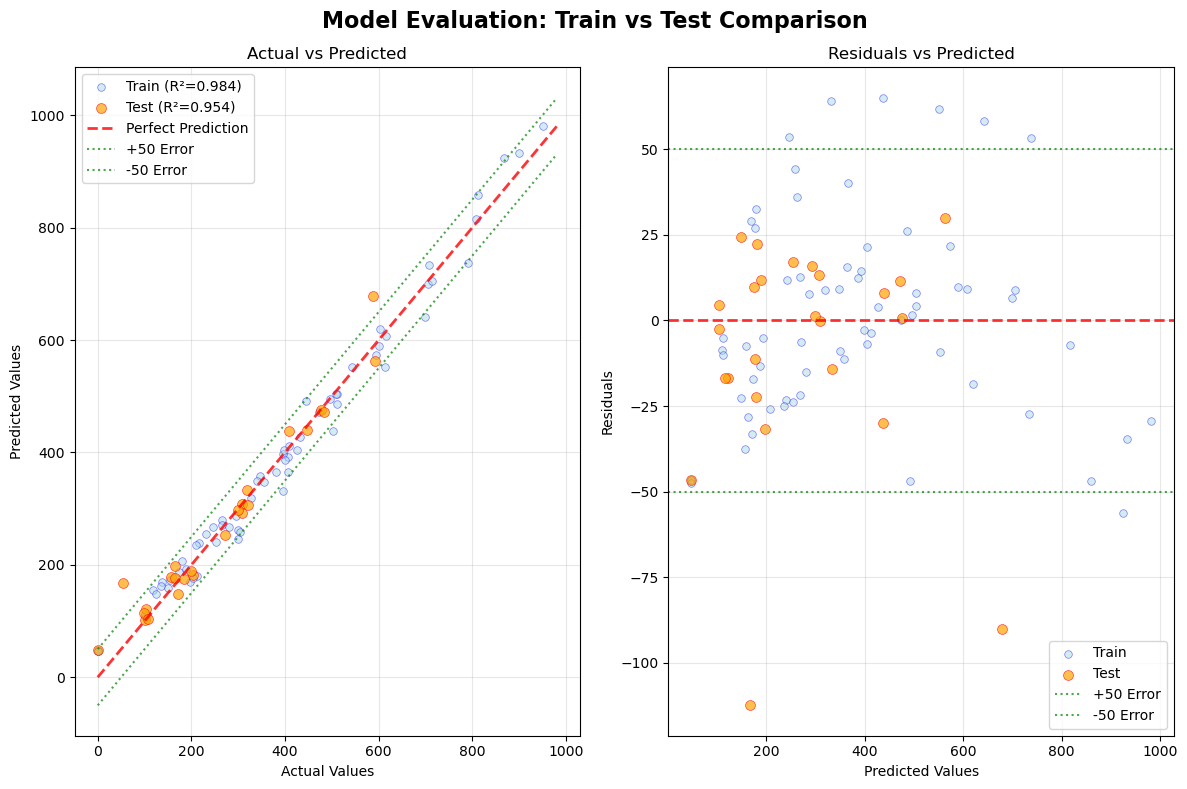

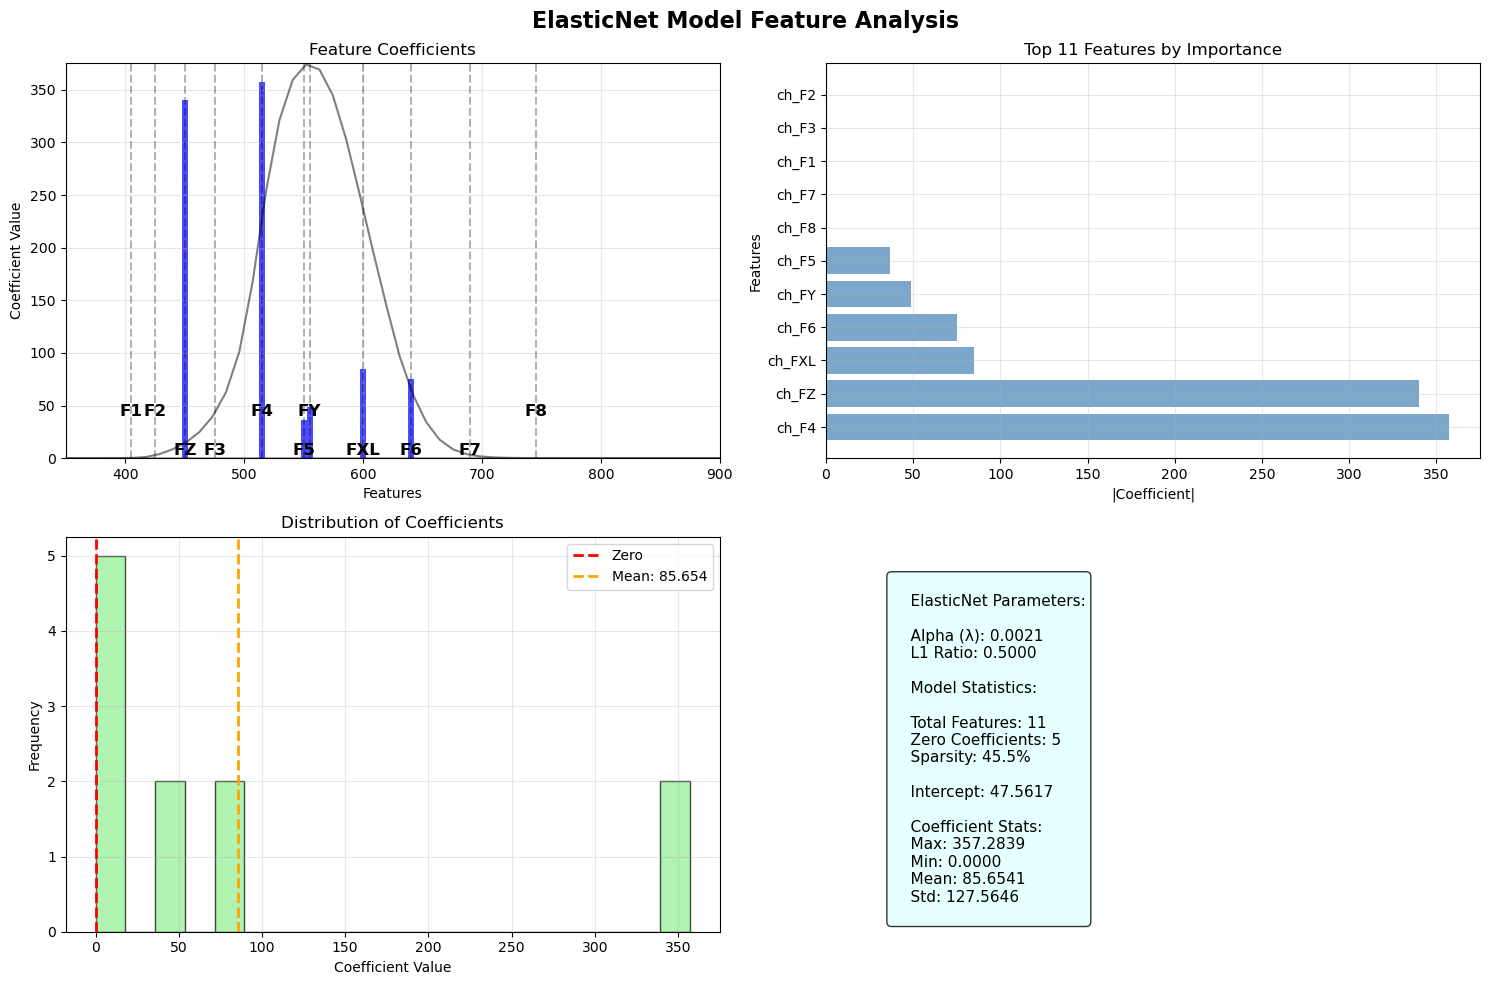

Exception ignored in: <function ResourceTracker.__del__ at 0x7ac0dd5ac720>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7396985ac720>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x72b9261ac720>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

In [24]:

from train import create_pipeline, evaluate_pipeline

features = [ c for c in data.columns if 'ch_F' in c]
print(features)
#sub = avg[avg.colortemp == 2500]
sub = avg.copy()

est = create_pipeline()
scores = evaluate_pipeline(est, sub)

scores